In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [2]:
# Define dataset paths
train_dir = r'C:\Users\ssid7\Desktop\Projects\MCA_Major_Project-Multimodal_Emotion_Recognition_System\data\train'
test_dir = r'C:\Users\ssid7\Desktop\Projects\MCA_Major_Project-Multimodal_Emotion_Recognition_System\data\test'

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  # Normalize pixel values
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values

# Load training and testing data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),  # Resize images to match VGG16 input
    color_mode="rgb",      # Convert grayscale to RGB for VGG16
    batch_size=64,
    class_mode='categorical'  # Assume one-hot encoded labels
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="rgb",
    batch_size=64,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Define the VGG model function
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Define and compile the model
model = create_vgg_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_data,
          validation_data=test_data,
          epochs=10)


Epoch 1/10


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 1350s 3s/step - accuracy: 0.3323 - loss: 1.6784 - val_accuracy: 0.5152 - val_loss: 1.2519
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1799s 4s/step - accuracy: 0.5115 - loss: 1.2822 - val_accuracy: 0.5673 - val_loss: 1.1484
Epoch 3/10
150/449 ━━━━━━━━━━━━━━━━━━━━ 17:48 4s/step - accuracy: 0.5723 - loss: 1.1574

In [ ]:
model.save("vgg_emotion_model.keras")

In [ ]:
# Create a feature extractor model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

In [ ]:
# Extract features from test data
features = feature_extractor.predict(test_data)
print("Extracted features shape:", features.shape)

113/113 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step
Extracted features shape: (7178, 256)


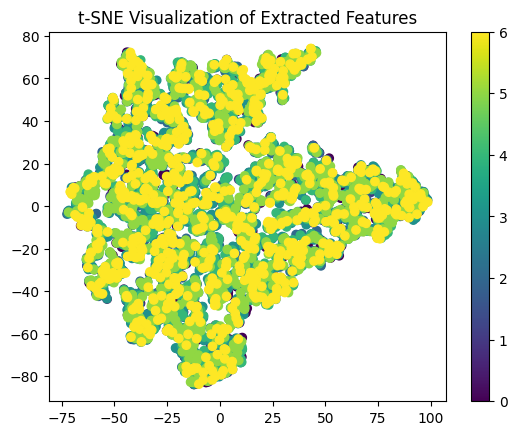

In [ ]:
# a) Visualize Features
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

# Plot the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=test_data.labels, cmap='viridis')
plt.colorbar()
plt.title("t-SNE Visualization of Extracted Features")
plt.show()

In [ ]:
# (b) Train a Classifier on Extracted Features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the test_data.labels to a single array
test_labels = test_data.labels

# Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(features, test_labels)

# Predict on the same features
predictions = clf.predict(features)
print("Accuracy:", accuracy_score(test_labels, predictions))


Accuracy: 0.270130955697966


In [ ]:
#(c) Store Features for Future Use
import numpy as np

# Save extracted features and corresponding labels
np.save("emotion_features.npy", features)
np.save("emotion_labels.npy", test_data.labels)


In [ ]:
# Deploy the Model
#(a) Load a New Image and Preprocess It
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img = image.load_img("/content/drive/MyDrive/Multimodel emotion recognition system/image/Fer 2013/test/happy/PrivateTest_10470092.jpg", target_size=(48, 48))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Extract features
features = feature_extractor.predict(img_array)
print("Extracted features:", features)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Extracted features: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.7463252e-01 0.0000000e+00 5.9795773e-01 0.0000000e+00 8.2471982e-02
  0.0000000e+00 7.4928530e-02 0.0000000e+00 4.6276861e-01 0.0000000e+00
  1.3004600e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.4491865e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.9122300e-01 4.2682296e-01 8.6312868e-02 0.0000000e+00 2.3867723e-01
  0.0000000e+00 7.1294546e-01 4.4718456e-01 0.0000000e+00 0.0000000e+00
  2.2772600e-01 0.0000000e+00 3.6120474e-01 0.0000000e+00 0.0000000e+00
  4.8733816e-02 0.0000000e+00 7.3960048e-01 6.0879868e-02 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6018963e-02 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.4863080e-01
  0.0000000e+00 7.6101569e-04 0.0000000e+00 0.0000000e+00 1.8172687e-01
  4.7262441e-02 5.0264275e-01 3.5627055e-01 0.0000000e+00 0.0000000e+00
  1.4

In [ ]:
# Define train_labels
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming you have a list or array of emotion labels for the training data (train_labels)
# Example labels, replace this with your actual labels from the training dataset
train_labels = ['happy', 'sad', 'angry', 'surprised', 'neutral', 'disgust', 'fearful', 'happy', 'sad', 'neutral']

# Initialize and fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)  # Fit the encoder on your emotion labels

# Now you can use the encoder to transform the labels into numeric values and inverse transform predictions


LabelEncoder()

In [ ]:
# Train the classifier
from sklearn.ensemble import RandomForestClassifier

# Assuming `train_features` is the list or array of features extracted from images
train_features = np.random.rand(10, 100)  # Example feature vectors

# Initialize the classifier
clf = RandomForestClassifier()

# Train the classifier with the features and the encoded labels
clf.fit(train_features, label_encoder.transform(train_labels))


RandomForestClassifier()

In [ ]:
# Predict and Inverse Transform
# Assuming `features` is the feature vector for the new data
features = np.random.rand(1, 100)  # Example new feature vector

# Predict the emotion
predicted_emotion = clf.predict(features)

# Convert numerical prediction back to emotion label
predicted_emotion_label = label_encoder.inverse_transform(predicted_emotion)

# Output the predicted emotion
print("Predicted emotion:", predicted_emotion_label)


Predicted emotion: ['happy']
